# Load data and Import packages

In [ ]:
!pip install ta
!pip install arch
!pip install pykalman
!pip install hmmlearn
!pip install yfinance

In [ ]:
### Bitcoin
import yfinance as yf
data = yf.download('BTC-USD' , period = '3y' , interval = '1d')

[*********************100%***********************]  1 of 1 completed


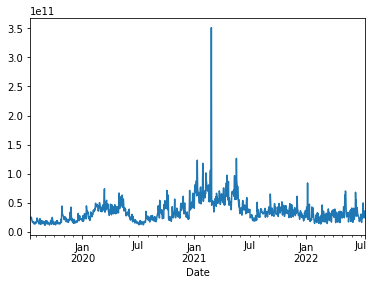

In [ ]:
data.Volume.plot()

In [ ]:
from pandas_datareader import data as web
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#data = web.DataReader(ticker,data_source='yahoo' ,start='2016-01-01',end='2021-02-14')
#!gdown --id 1mX13M51X2U1y7b9IQ1FEQqkTQ1IR3q0i
#data = pd.read_csv('/content/NQH21-CME.csv')




### General
data['Returns']= data.Close.pct_change()*100

columns = data.columns

for i in columns:
  data[f'{i.lower()}'] = data[f'{i}'].shift(1)


data['squre_Return']= data['returns']**2
data.dropna(0, inplace= True)

close = data.close
high = data.high
low = data.low
open = data.open
volume = data.volume
#adj_close = data['adj close']
returns = data['returns']
alpha = pd.DataFrame(index=data.index)

data = data.iloc[400:2000]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only


# Regime Analysis

In [ ]:
from arch.univariate import GARCH, EGARCH , arch_model , HARCH

am = arch_model(data.returns, vol='harch', p=[1, 5, 22], dist="skewt")
harch_sk = am.fit(update_freq=5 , disp='off')

am = arch_model(data.returns, vol='EGarch', p=1, o=1, q=1, dist="skewt")
egarch_sk = am.fit(update_freq=5 , disp='off')
conditional_vol_egarch = egarch_sk.conditional_volatility

In [ ]:
from hmmlearn.hmm import GaussianHMM
import ta

data['psar_down_indicator']=ta.trend.psar_down_indicator(data.High, data.Low, data.Close, step=0.02, max_step=0.2, fillna=False)
data['psar_up_indicator']=ta.trend.psar_up_indicator(data.High, data.Low, data.Close, step=0.02, max_step=0.2, fillna=False)
data['PSAR_Regime'] = ta.trend.psar_down(data.High, data.Low, data.Close, step=0.02, max_step=0.2, fillna=False)

data.PSAR_Regime[data.PSAR_Regime.notnull()] =1
data.PSAR_Regime[data.PSAR_Regime.isnull()] = 0

## Returns
states = 2
hmm_model= GaussianHMM(n_components= states, covariance_type="full", n_iter=1000).fit(data[['returns']].values)
data['Return_Regime'] = hmm_model.predict(data[["returns"]].values)


## Squared Returns
data['sq_return'] = data.returns ** 2
states = 2
hmm_model = GaussianHMM(n_components= states, covariance_type="full", n_iter=1000).fit(data[['sq_return']].values)
data['Squared_Return_Regime'] = hmm_model.predict(data[["sq_return"]].values)


## Conditional Volatility
states = 2
hmm_model = GaussianHMM(n_components= states, covariance_type="full", n_iter=1000).fit(conditional_vol_egarch.values.reshape(-1,1))
data['Conditional_Volatility_Regime'] = hmm_model.predict(conditional_vol_egarch.values.reshape(-1,1))


### OHLC
states = 2
OHLC = ['Volume', "sq_return"]
hmm_model = GaussianHMM(n_components= states, covariance_type="full", n_iter=1000).fit(data[OHLC].values)
data['OHLC_Regime'] = hmm_model.predict(data[OHLC].values)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

# Directional Change

In [ ]:
import pandas as pd

def generate(data, d=0.04):
    """Generates directional change events from time series.
    Based on:
        M. Aloud, E. Tsang, R. B. Olsen, and A. Dupuis, "A Directional-Change Events Approach for Studying Financial Time Series," 2012.
    Args:
        data: pandas.Series or array of floats
        d: Directional Change threshold
    Returns:
        A pandas series of Directional Change Events.
    """

    p = pd.DataFrame({
    "Price": data
    })
    p["Event"] = ''
    event = 'upturn'
    ph = p['Price'][0] # highest price
    pl = ph # lowest price

    for i in range(0, len(p)):

        if event is 'upturn':
            if p['Price'][i] <= (ph * (1 - d)):
                event = 'downturn'
                pl = p['Price'][i]
                p.at[i, 'Event'] = 'end downturn'
                p.at[i + 1, 'Event'] = 'start downward os'

            else:
                if ph < p['Price'][i]:
                    ph = p['Price'][i]
                    p.at[i, 'Event'] = 'start downturn'
                    p.at[i - 1, 'Event'] = 'end upward os'
        else:
            if p['Price'][i] >= (pl * (1 + d)):
                event = 'upturn'
                ph = p['Price'][i]
                p.at[i, 'Event'] = 'end upturn'
                p.at[i + 1, 'Event'] = 'start upward os'

            else:
                if pl > p['Price'][i]:
                    pl = p['Price'][i]
                    p.at[i, 'Event'] = 'start upturn'
                    p.at[i - 1, 'Event'] = 'end downward os'

    return p['Event']

# Plot

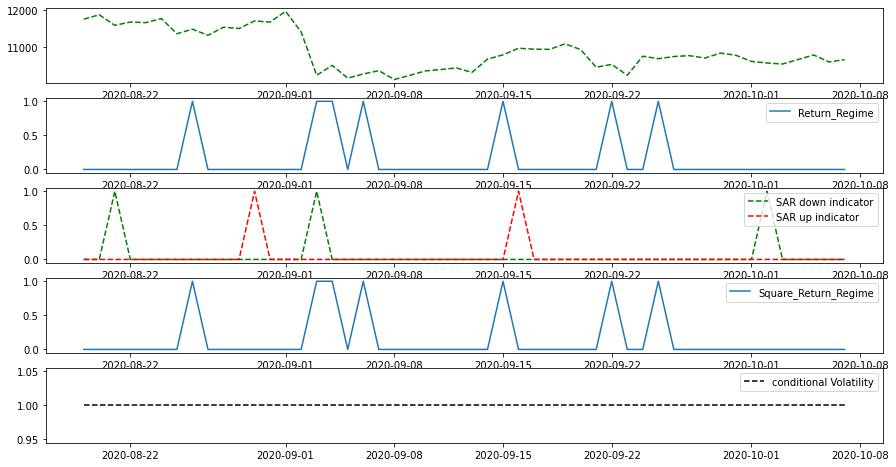

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax1 = fig.add_subplot(5, 1, 1)
plt.plot(data.Close[0:50] , 'g--')

ax2 = fig.add_subplot(5, 1, 2)
plt.plot(data.Return_Regime[0:50] , label ='Return_Regime')
plt.legend(loc='best')


ax3= fig.add_subplot(5, 1, 3)

plt.plot(data['psar_down_indicator'][0:50] , 'g--' , label = 'SAR down indicator')
plt.plot(data['psar_up_indicator'][0:50] , 'r--' , label = 'SAR up indicator')
plt.legend(loc='best')

ax2 = fig.add_subplot(5, 1, 4)
plt.plot(data.Squared_Return_Regime [0:50] , label ='Square_Return_Regime')
plt.legend(loc='best')


ax4= fig.add_subplot(5, 1, 5)
plt.plot(data.Conditional_Volatility_Regime[0:50] , 'k--' , label = 'conditional Volatility')
plt.legend(loc='best')

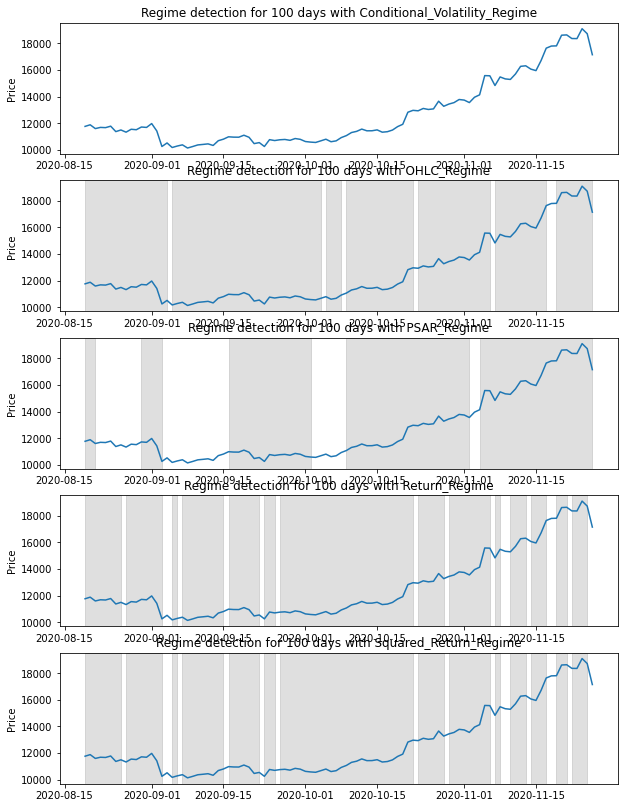

In [ ]:
days = 100 # you can choice the number of trial days for visulaization
regime_columns = sorted(data.filter(like='egime').columns) # all columns who is related to regime change, is selected
fig, axes = plt.subplots(len(regime_columns), figsize=(10,14))


for j in range(len(regime_columns)):
  axes[j].plot(data.Close[:days])
  col = regime_columns[j]
  axes[j].set_title('Regime detection for {} days with {}'.format(days , col ))
  axes[j].set_ylabel('Price')


  start = []
  stop = []
  for i in range(days):
    if data[col].iloc[i]== 1 and data[col].shift(1).iloc[i]!=1:
      start.append(data[col].index[i])
    if data[col].iloc[i]== 0 and data[col].shift(1).iloc[i]!=0:
      stop.append(data[col].index[i])

  for st , end in zip(start , stop):
      axes[j].axvspan(xmin=st, xmax= end , color = 'gray' , alpha=0.25, zorder=0.6)